# Implementação
A primeira parte deste notebook contém a implementação do método FastICA dividida em três classes, como explicado na monografia. No final é apresentada uma forma de utilizar o código apresentado. Vale notar que é possível que o código não rode apenas executando-o: Nesse caso é necessário comentar as linhas que envolvem a função do papi. O que acontece é que para medir as operações de ponto flutuante o papi necessita de acesso a uma flag do kernel do Linux que pode estar bloqueado por padrão no computador de quem o executa. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA
from pypapi import events, papi_high as high
from abc import ABC, abstractmethod
from __future__ import annotations

class preprocessing:
    def __init__(self, mat):
        self.mat = mat

    def center(self):

        rows, cols = np.shape(self.mat)

        mean = np.mean(self.mat, axis=1, keepdims=True)
        new_matrix = self.mat - mean
        self.mat = new_matrix

        return self.mat

    def covMatrix(self):

        num_samples = np.shape(self.mat)[1]

        self.center()

        cov_mat = np.dot(self.mat, self.mat.T)
        cov_mat = cov_mat / num_samples

        return cov_mat
    
    def sphering(self):

        self.center()
        cov = self.covMatrix()

        D, E = np.linalg.eig(cov)

        diag = np.zeros((len(D), len(D)))

        for i in range(len(D)):
            diag[i][i] = 1.0 / np.sqrt(np.absolute(D[i]))

        V = np.dot(diag, E.T)

        return V

class fastICA:
    def __init__(self, z, func: ContrastFunction, convergence_parameter = False):
        self.z = z
        self.func = func
        self.convergence_parameter = convergence_parameter

    def normalize(self, w):
        square_norm = 0.0

        for w_i in w:
            square_norm = square_norm + w_i**2

        norm = np.sqrt(square_norm)

        nw = w / norm

        return nw

    def fastICA(self):
        z = self.z

        # Quantidade de componentes que queremos estimar
        # e quantidade de observações que cada mistura tem
        m, n = np.shape(z)

        p = 1

        W = np.array([np.zeros(m)])

        while p <= m:

            # w tem que ter dimensao m

            wp = np.random.rand(m)

            wp = self.normalize(wp)

            wp_prev = np.zeros(m)

            count = 0
            
            while 1 - np.dot(wp, wp_prev.T) >= 1e-8:

                wp_prev = wp

                k_value = self.func.k(np.dot(wp, z))
                kPrime_value = self.func.kPrime(np.dot(wp, z))

                if self.convergence_parameter == True:
                    wp = (np.mean(z * k_value, axis=1) - 0.01 * np.mean(kPrime_value) * wp)
                else:
                    wp = (np.mean(z * k_value, axis=1) - np.mean(kPrime_value) * wp)

                summation = 0.0

                for j in range(1, p):

                    summation = summation + np.dot(np.dot(wp.T, W[j, :]), W[j, :])

                wp = wp - summation

                wp = self.normalize(wp)
                
                count = count + 1
                

            W = np.concatenate((W, [wp]), axis=0)

            p = p + 1
            

        return W[1:m+1, :]

class ContrastFunction(ABC):
    @abstractmethod
    def k(self, arr):
        pass
    
    @abstractmethod
    def kPrime(self, arr):
        pass
    
class ContrastFunctionTanh(ContrastFunction):
    def k(self, arr):
        return np.tanh(arr)
    
    def kPrime(self, arr):
        t = np.tanh(arr)

        return 1 - np.square(t)
    
class ContrastFunctionEuler(ContrastFunction):
    def k(self, arr):
        return arr*np.exp(-(arr**2)/2)
    
    def kPrime(self, arr):
        return (np.exp(-(arr**2)/2))*(1 - arr**2)
    
class ContrastFunctionCube(ContrastFunction):
    def k(self, arr):
        return arr**3
    
    def kPrime(self, arr):
        return 3*arr**2
    
def performance_index(P):
    m = np.shape(P)[0]
    E1 = 0.0
    
    # vamos calcular os valores máximos para cada linha e tambem para cada coluna
    max_r = np.zeros(m)
    max_c = np.zeros(m)
    for i in range(m):
        for j in range(m):
            if np.abs(P[i][j]) > max_r[i]:
                max_r[i] = np.abs(P[i][j])
                
            if np.abs(P[i][j]) > max_c[j]:
                max_c[j] = np.abs(P[i][j])
                
    # com isso podemos calcular o indice de performance
    for i in range(m):
        for j in range(m):
            e = np.abs(P[i][j]) / max_r[i]
            E1 += e
            
        E1 -= 1
                    
    for j in range(m):
        for i in range(m):
            e = np.abs(P[i][j]) / max_c[j]
            
            E1 += e
            
        E1 -= 1
            
    return E1    



# Exemplo de como aplicar o FastICA desenvolvido neste código:

num_samples = np.linspace(0, 200, 1000)

#s = np.array([np.sin(num_samples*1.15),
#              signal.sawtooth(num_samples * 2.0),
#              np.random.random(len(num_samples))])

#s = np.array([np.sin(num_samples),
#             np.sin(num_samples*1.12),
#             signal.sawtooth(num_samples * 2.3)])

#s = np.array([np.sin(num_samples),
#              np.sin(num_samples*1.74),
#              np.sin(num_samples*0.23)])

#s = np.array([signal.sawtooth(num_samples),
#             np.sin(num_samples*1.17) + np.cos(num_samples*2.31),
#             signal.sweep_poly(num_samples, np.poly1d([0.23, -0.53, 1.15, 0.41]))])

#s = np.array([signal.chirp(num_samples, f0=6, f1=1, t1=200),
#             signal.sawtooth(num_samples),
#             np.sin(num_samples*1.23)])

s = np.array([np.sin(num_samples*1.15),
              signal.sawtooth(num_samples * 2.0),
              np.random.random(len(num_samples))])

A = np.random.rand(3, 3)

#A = np.array([[0.5, 1, 0.2],
#             [1, 0.5, 0.4],
#             [0.5, 0.8, 1]])

x = np.dot(A, s)

prep = preprocessing(x)

V = prep.sphering()

z = np.dot(V, x)

prepS = preprocessing(z)

covS = prepS.covMatrix()

fast_ica = fastICA(z, ContrastFunctionEuler(), False)

W = fast_ica.fastICA()

# Testagem
## Primeiro vetor de fontes

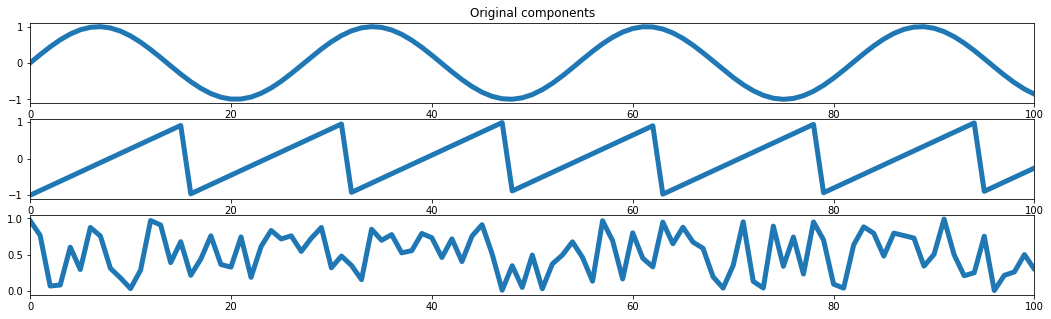

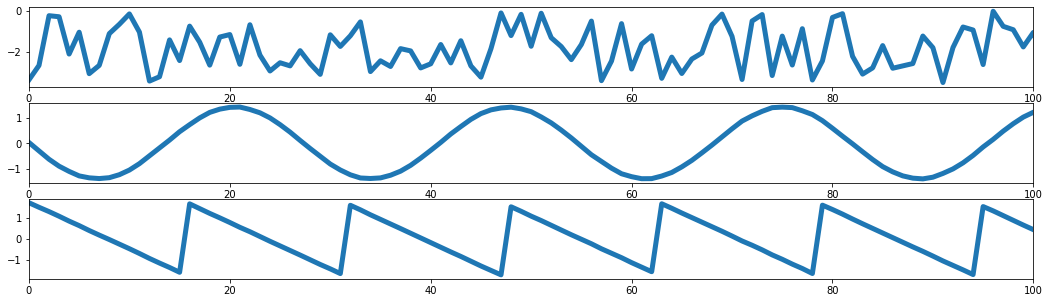

In [2]:
s = np.array([np.sin(num_samples*1.15),
              signal.sawtooth(num_samples * 2.0),
              np.random.random(len(num_samples))])

ETanh = []
EEuler = []
ECube = []
ESklearn = []
perfTanh = []
perfEuler = []
perfCube = []
perfSklearn = []


A = np.random.rand(3, 3)
x = np.dot(A, s)
prep = preprocessing(x)
high.start_counters([events.PAPI_DP_OPS,])
V = prep.sphering()
perfSphering = high.stop_counters()
z = np.dot(V, x)

#Measures using the Tanh() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICATanh = fastICA(z, ContrastFunctionTanh(), False)
WTanh = fastICATanh.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfTanh.append(perf)
ETanh.append(performance_index(np.dot(np.dot(WTanh, V), A)))

#Measures using the Euler() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICAEuler = fastICA(z, ContrastFunctionEuler(), False)
WEuler = fastICAEuler.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfEuler.append(perf)
EEuler.append(performance_index(np.dot(np.dot(WEuler, V), A)))

#Measures using the Cube contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICACube = fastICA(z, ContrastFunctionCube(), True)
WCube = fastICACube.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfCube.append(perf)
ECube.append(performance_index(np.dot(np.dot(WCube, V), A)))

#Measures using the scikit-learn implementation
high.start_counters([events.PAPI_DP_OPS,])
fastICASklearn = FastICA(n_components=3, max_iter=1000, tol=1e-8, algorithm='deflation', whiten='unit-variance')
fastICASklearn.fit(x.T)
WSolver = fastICASklearn.components_
perfSklearn.append(high.stop_counters())
ESklearn.append(performance_index(np.dot(WSolver, A)))

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(s[0], lw=5)
ax[0].set_title("Original components")
ax[0].set_xlim(0, 100)

ax[1].plot(s[1], lw=5)
#ax[1].set_title("Original components")
ax[1].set_xlim(0, 100)

ax[2].plot(s[2], lw=5)
#ax[2].set_title("Original components")
ax[2].set_xlim(0, 100)

sTanh = np.dot(z.T, WTanh.T)

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(sTanh.T[0], lw=5)
ax[0].set_xlim(0, 100)
#ax[0].set_title("Unmixed signals using the tanh() contrast function")

ax[1].plot(sTanh.T[1], lw=5)
ax[1].set_xlim(0, 100)

ax[2].plot(sTanh.T[2], lw=5)
ax[2].set_xlim(0, 100)

plt.show()

## Segundo vetor de fontes

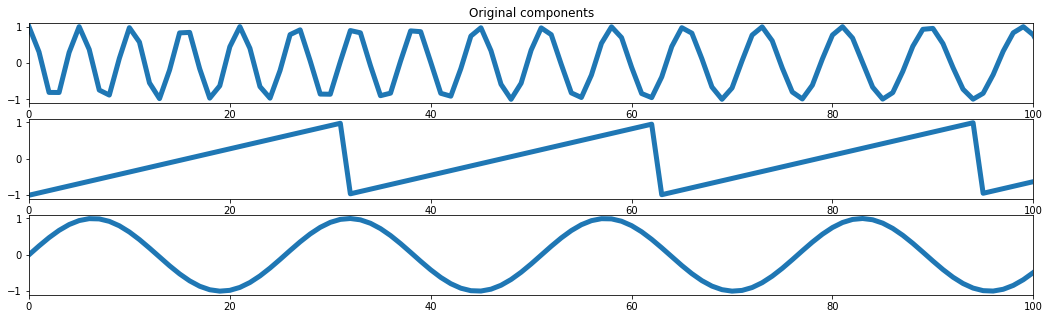

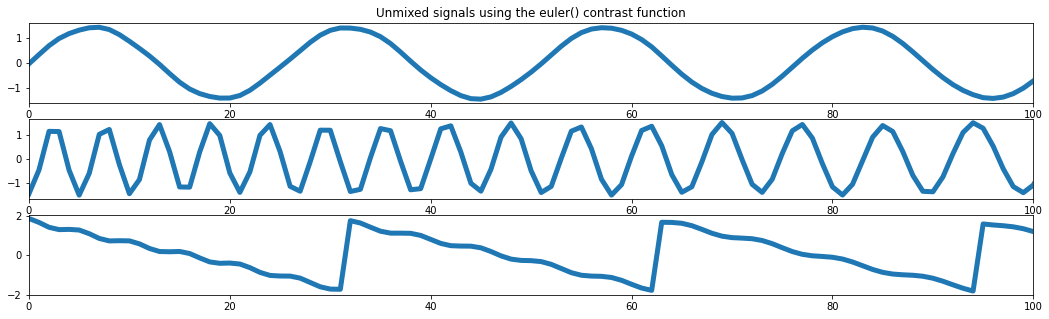

In [3]:
s = np.array([signal.chirp(num_samples, f0=6, f1=1, t1=200),
             signal.sawtooth(num_samples),
             np.sin(num_samples*1.23)])

A = np.random.rand(3, 3)
x = np.dot(A, s)
prep = preprocessing(x)
V = prep.sphering()
z = np.dot(V, x)

#Measures using the Tanh() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICATanh = fastICA(z, ContrastFunctionTanh(), False)
WTanh = fastICATanh.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfTanh.append(perf)
ETanh.append(performance_index(np.dot(np.dot(WTanh, V), A)))

#Measures using the Euler() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICAEuler = fastICA(z, ContrastFunctionEuler(), False)
WEuler = fastICAEuler.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfEuler.append(perf)
EEuler.append(performance_index(np.dot(np.dot(WEuler, V), A)))

#Measures using the Cube contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICACube = fastICA(z, ContrastFunctionCube(), True)
WCube = fastICACube.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfCube.append(perf)
ECube.append(performance_index(np.dot(np.dot(WCube, V), A)))

#Measures using the scikit-learn implementation
high.start_counters([events.PAPI_DP_OPS,])
fastICASklearn = FastICA(n_components=3, max_iter=1000, tol=1e-8, algorithm='deflation', whiten='unit-variance')
fastICASklearn.fit(x.T)
WSolver = fastICASklearn.components_
perfSklearn.append(high.stop_counters())
ESklearn.append(performance_index(np.dot(WSolver, A)))

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(s[0], lw=5)
ax[0].set_title("Original components")
ax[0].set_xlim(0, 100)

ax[1].plot(s[1], lw=5)
#ax[1].set_title("Original components")
ax[1].set_xlim(0, 100)

ax[2].plot(s[2], lw=5)
#ax[2].set_title("Original components")
ax[2].set_xlim(0, 100)

sEuler = np.dot(z.T, WEuler.T)

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(sEuler.T[0], lw=5)
ax[0].set_xlim(0, 100)
ax[0].set_title("Unmixed signals using the euler() contrast function")

ax[1].plot(sEuler.T[1], lw=5)
ax[1].set_xlim(0, 100)

ax[2].plot(sEuler.T[2], lw=5)
ax[2].set_xlim(0, 100)

plt.show()

## Terceiro vetor de fontes

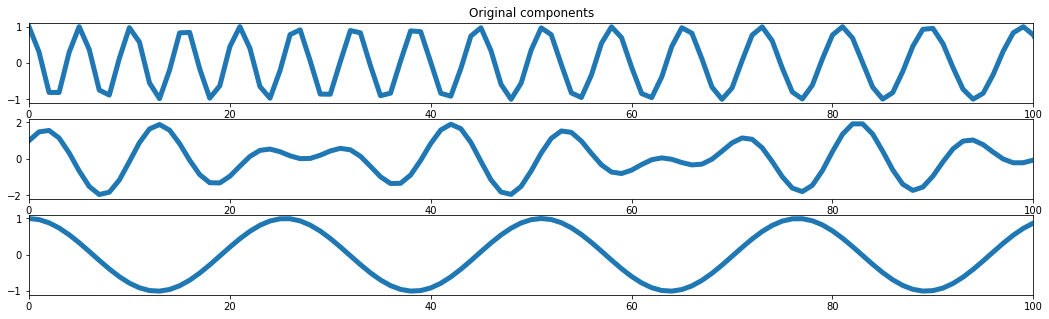

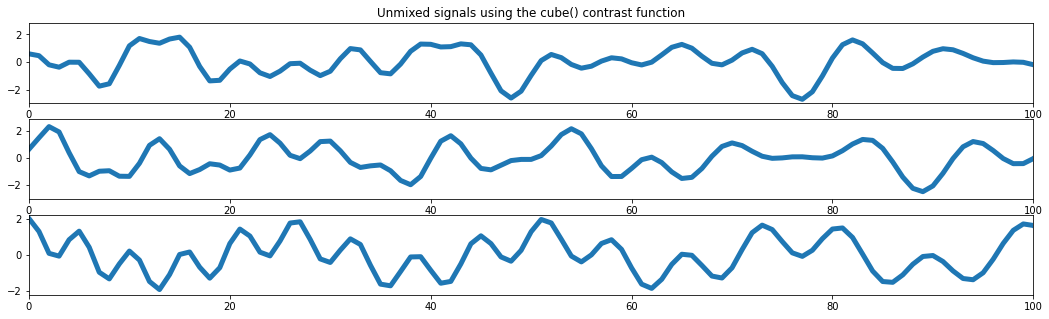

In [4]:
s = np.array([signal.chirp(num_samples, f0=6, f1=1, t1=200),
             np.sin(num_samples*3.14) + np.cos(num_samples*2.28),
             np.cos(num_samples*1.23)])

A = np.random.rand(3, 3)
x = np.dot(A, s)
prep = preprocessing(x)
V = prep.sphering()
z = np.dot(V, x)

#Measures using the Tanh() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICATanh = fastICA(z, ContrastFunctionTanh(), False)
WTanh = fastICATanh.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfTanh.append(perf)
ETanh.append(performance_index(np.dot(np.dot(WTanh, V), A)))

#Measures using the Euler() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICAEuler = fastICA(z, ContrastFunctionEuler(), False)
WEuler = fastICAEuler.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfEuler.append(perf)
EEuler.append(performance_index(np.dot(np.dot(WEuler, V), A)))

#Measures using the Cube contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICACube = fastICA(z, ContrastFunctionCube(), True)
WCube = fastICACube.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfCube.append(perf)
ECube.append(performance_index(np.dot(np.dot(WCube, V), A)))

#Measures using the scikit-learn implementation
high.start_counters([events.PAPI_DP_OPS,])
fastICASklearn = FastICA(n_components=3, max_iter=1000, tol=1e-8, algorithm='deflation', whiten='unit-variance')
fastICASklearn.fit(x.T)
WSolver = fastICASklearn.components_
perfSklearn.append(high.stop_counters())
ESklearn.append(performance_index(np.dot(WSolver, A)))

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(s[0], lw=5)
ax[0].set_title("Original components")
ax[0].set_xlim(0, 100)

ax[1].plot(s[1], lw=5)
#ax[1].set_title("Original components")
ax[1].set_xlim(0, 100)

ax[2].plot(s[2], lw=5)
#ax[2].set_title("Original components")
ax[2].set_xlim(0, 100)

sCube = np.dot(z.T, WCube.T)

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(sCube.T[0], lw=5)
ax[0].set_xlim(0, 100)
ax[0].set_title("Unmixed signals using the cube() contrast function")

ax[1].plot(sCube.T[1], lw=5)
ax[1].set_xlim(0, 100)

ax[2].plot(sCube.T[2], lw=5)
ax[2].set_xlim(0, 100)

plt.show()

## Quarto vetor de fontes

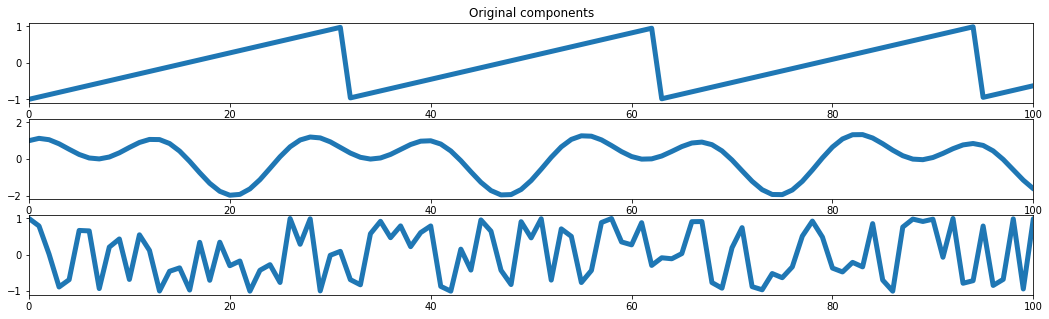

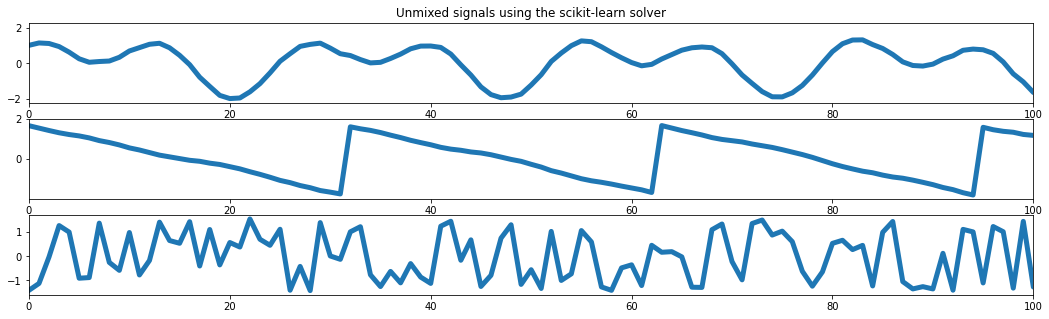

In [5]:
s = np.array([signal.sawtooth(num_samples),
             np.sin(num_samples*1.17) + np.cos(num_samples*2.31),
             signal.sweep_poly(num_samples, np.poly1d([0.23, -0.53, 1.15, 0.41]))])

A = np.random.rand(3, 3)
x = np.dot(A, s)
prep = preprocessing(x)
V = prep.sphering()
z = np.dot(V, x)

#Measures using the Tanh() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICATanh = fastICA(z, ContrastFunctionTanh(), False)
WTanh = fastICATanh.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfTanh.append(perf)
ETanh.append(performance_index(np.dot(np.dot(WTanh, V), A)))

#Measures using the Euler() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICAEuler = fastICA(z, ContrastFunctionEuler(), False)
WEuler = fastICAEuler.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfEuler.append(perf)
EEuler.append(performance_index(np.dot(np.dot(WEuler, V), A)))

#Measures using the Cube contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICACube = fastICA(z, ContrastFunctionCube(), True)
WCube = fastICACube.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfCube.append(perf)
ECube.append(performance_index(np.dot(np.dot(WCube, V), A)))

#Measures using the scikit-learn implementation
high.start_counters([events.PAPI_DP_OPS,])
fastICASklearn = FastICA(n_components=3, max_iter=1000, tol=1e-8, algorithm='deflation', whiten='unit-variance')
fastICASklearn.fit(x.T)
WSolver = fastICASklearn.components_
perfSklearn.append(high.stop_counters())
ESklearn.append(performance_index(np.dot(WSolver, A)))

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(s[0], lw=5)
ax[0].set_title("Original components")
ax[0].set_xlim(0, 100)

ax[1].plot(s[1], lw=5)
#ax[1].set_title("Original components")
ax[1].set_xlim(0, 100)

ax[2].plot(s[2], lw=5)
#ax[2].set_title("Original components")
ax[2].set_xlim(0, 100)

sSklearn = fastICASklearn.fit_transform(x.T)

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(sSklearn.T[0], lw=5)
ax[0].set_xlim(0, 100)
ax[0].set_title("Unmixed signals using the scikit-learn solver")

ax[1].plot(sSklearn.T[1], lw=5)
ax[1].set_xlim(0, 100)

ax[2].plot(sSklearn.T[2], lw=5)
ax[2].set_xlim(0, 100)

plt.show()

## Quinto vetor de fontes

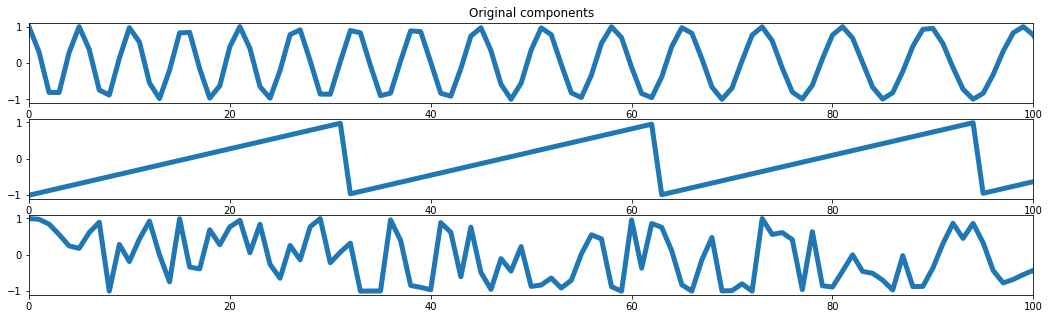

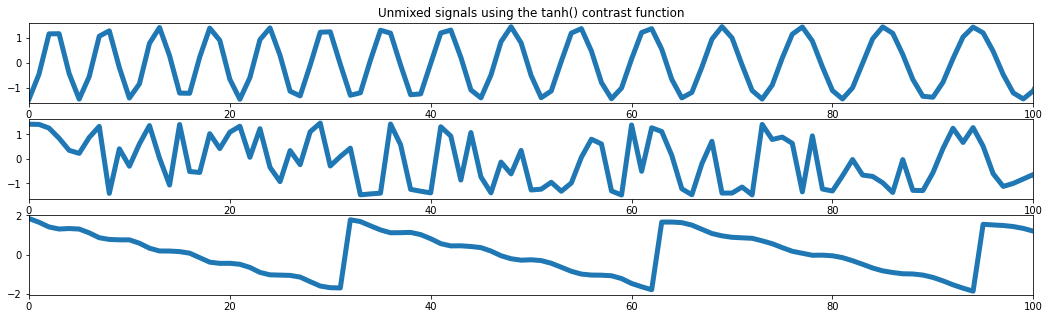

In [6]:
s = np.array([signal.chirp(num_samples, f0=6, f1=1, t1=200),
             signal.sawtooth(num_samples),
             signal.sweep_poly(num_samples, np.poly1d([-1.12, 0.32, 0.57, 0.11]))])

A = np.random.rand(3, 3)
x = np.dot(A, s)
prep = preprocessing(x)
V = prep.sphering()
z = np.dot(V, x)

#Measures using the Tanh() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICATanh = fastICA(z, ContrastFunctionTanh(), False)
WTanh = fastICATanh.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfTanh.append(perf)
ETanh.append(performance_index(np.dot(np.dot(WTanh, V), A)))

#Measures using the Euler() contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICAEuler = fastICA(z, ContrastFunctionEuler(), False)
WEuler = fastICAEuler.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfEuler.append(perf)
EEuler.append(performance_index(np.dot(np.dot(WEuler, V), A)))

#Measures using the Cube contrast function
high.start_counters([events.PAPI_DP_OPS,])
fastICACube = fastICA(z, ContrastFunctionCube(), True)
WCube = fastICACube.fastICA()
perf = high.stop_counters()
perf = perf[0] + perfSphering[0]
perfCube.append(perf)
ECube.append(performance_index(np.dot(np.dot(WCube, V), A)))

#Measures using the scikit-learn implementation
high.start_counters([events.PAPI_DP_OPS,])
fastICASklearn = FastICA(n_components=3, max_iter=1000, tol=1e-8, algorithm='deflation', whiten='unit-variance')
fastICASklearn.fit(x.T)
WSolver = fastICASklearn.components_
perfSklearn.append(high.stop_counters())
ESklearn.append(performance_index(np.dot(WSolver, A)))

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(s[0], lw=5)
ax[0].set_title("Original components")
ax[0].set_xlim(0, 100)

ax[1].plot(s[1], lw=5)
#ax[1].set_title("Original components")
ax[1].set_xlim(0, 100)

ax[2].plot(s[2], lw=5)
#ax[2].set_title("Original components")
ax[2].set_xlim(0, 100)

sTanh = np.dot(z.T, WTanh.T)

fig, ax = plt.subplots(3, 1, figsize=[18, 5])
ax[0].plot(sTanh.T[0], lw=5)
ax[0].set_xlim(0, 100)
ax[0].set_title("Unmixed signals using the tanh() contrast function")

ax[1].plot(sTanh.T[1], lw=5)
ax[1].set_xlim(0, 100)

ax[2].plot(sTanh.T[2], lw=5)
ax[2].set_xlim(0, 100)

plt.show()

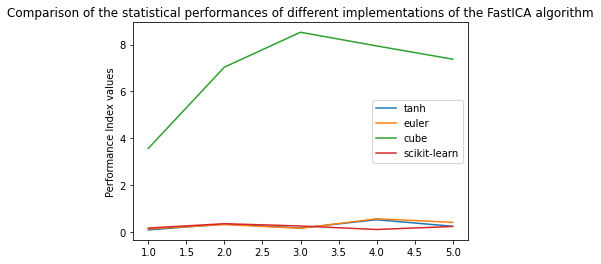

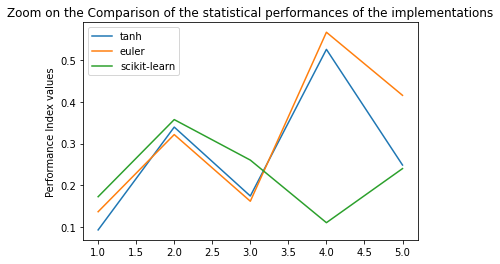

In [7]:
counter = [1, 2, 3, 4, 5]

plt.plot(counter, ETanh, label='tanh')
plt.plot(counter, EEuler, label='euler')
plt.plot(counter, ECube, label='cube')
plt.plot(counter, ESklearn, label='scikit-learn')
plt.title("Comparison of the statistical performances of different implementations of the FastICA algorithm")
plt.ylabel("Performance Index values")
plt.legend()

plt.show()


plt.plot(counter, ETanh, label='tanh')
plt.plot(counter, EEuler, label='euler')
plt.plot(counter, ESklearn, label='scikit-learn')
plt.title("Zoom on the Comparison of the statistical performances of the implementations")
plt.ylabel("Performance Index values")
plt.legend()

plt.show()

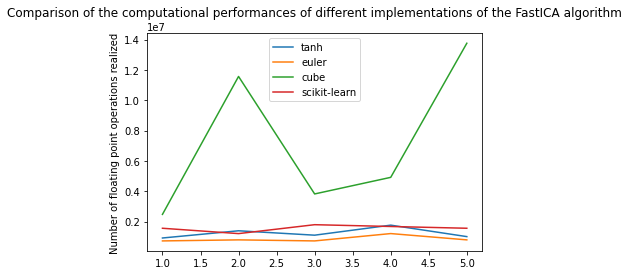

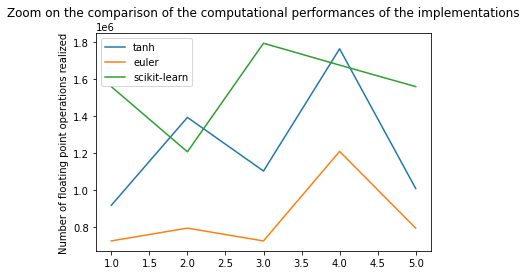

In [10]:
plt.plot(counter, perfTanh, label='tanh')
plt.plot(counter, perfEuler, label='euler')
plt.plot(counter, perfCube, label='cube')
plt.plot(counter, perfSklearn, label='scikit-learn')
plt.title("Comparison of the computational performances of different implementations of the FastICA algorithm")
plt.ylabel("Number of floating point operations realized")
plt.legend()

plt.show()

plt.plot(counter, perfTanh, label='tanh')
plt.plot(counter, perfEuler, label='euler')
plt.plot(counter, perfSklearn, label='scikit-learn')
plt.title("Zoom on the comparison of the computational performances of the implementations")
plt.ylabel("Number of floating point operations realized")
plt.legend()

plt.show()

